# eXtreme MultiLabel (XML) Classification

A classification task is defined as 'extreme' when the number of classes considered grows considerably (from a dozen to millions of classes). The 'Multilabel' problem is similare to a classification task, but each sample may have more than one associated label. Furthermore, any sample may have a different number of associated labels.

This notebook aims to proove that naives approaches may not be either performant nor mathematically correct for this problem, and to show a simplified version of the XML method developed in paper [**Deep Extreme Multi-label Learning**](https://arxiv.org/pdf/1704.03718.pdf) by Zhang et al.

In [2]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor

# Theory: label independance

A multi-label problem is different from a multi-class one as the latter only attributes the most probable one class for a sample, whereas the multi-label problem needs to attributes the most probable subset of classes.

For instance, in visual recognition a multi-class problem would be to recognise the main subject of a picture whereas a multi-label problem would be the recognition of all recognizable objects in the picture.

At first one could think that the subset of the most probable classes would form the most probable subset of classes, but it is not true on the general case. It can only be true if each class probability is independent from the others (or $P(A\,|\, B) = P(A) $ for each A,B classes in our problem). **This hypothesis can't possibly be satisfied in most of our problems**.

That's what makes mult-label so tricky. Indeed the number of classes subset is much larger than the number of classes (growing as $2^N$, with N classes. That means multilabelling with 100 labels makes a little more than a 1 million classes classification problem. Scaling to 100 labels would have us have to choose between $ 1,26 . 10^{30}$ possible subsets.

Thus there's a need for a reasonable approach.

# Birds chant recognition

We'll follow through this reasoning using data from [The 9th annual MLSP competition: New methods for acoustic classification of multiple simultaneous bird species in a noisy environment]( http://vintage.winklerbros.net/Publications/mlsp2013ma.pdf ).

This data represents audio recordings of birds chants, with the objective of recognising up to 19 different birds. It has been split for the sake of this exercise.

In [3]:
# Get data
X_train, X_test = np.loadtxt('data/X_train_birds.txt'), np.loadtxt('data/X_test_birds.txt')
y_train, y_test = np.loadtxt('data/y_train_birds.txt'), np.loadtxt('data/y_test_birds.txt')
birds_list = ["Brown Creeper","Pacific Wren","Pacific-slope Flycatcher","Red-breasted Nuthatch",
              "Dark-eyed Junco","Olive-sided Flycatcher","Hermit Thrush","Chestnut-backed Chickadee",
              "Varied Thrush","Hermit Warbler","Swainson's Thrush","Hammond's Flycatcher",
              "Western Tanager","Black-headed Grosbeak","Golden Crowned Kinglet","Warbling Vireo",
              "MacGillivray's Warbler","Stellar's Jay","Common Nighthawk"]

<div class="alert alert-warning">Let's look at the data to picture the multilabel problem</div>

In [5]:
print(len(X_train), ' train samples and ', len(X_test), ' test sample')
print('###')
for i in range(len(birds_list)):
    print(' Species {} appears {} times'.format(birds_list[i], np.sum(y_train[:,i]) + np.sum(y_test[:,i])))
print('###')
all_y = np.concatenate([y_train, y_test])
all_sum_y = np.sum(all_y, axis=1)
print('As a mean {} species appear on each recording (standard deviation {})'.format(np.mean(all_sum_y), np.std(all_sum_y)))

# Remark that the repartion of occurence between species is quite unequal, which would tend to biase black-block approaches

322  train samples and  323  test sample
###
 Species Brown Creeper appears 14.0 times
 Species Pacific Wren appears 81.0 times
 Species Pacific-slope Flycatcher appears 46.0 times
 Species Red-breasted Nuthatch appears 9.0 times
 Species Dark-eyed Junco appears 20.0 times
 Species Olive-sided Flycatcher appears 14.0 times
 Species Hermit Thrush appears 47.0 times
 Species Chestnut-backed Chickadee appears 40.0 times
 Species Varied Thrush appears 61.0 times
 Species Hermit Warbler appears 53.0 times
 Species Swainson's Thrush appears 103.0 times
 Species Hammond's Flycatcher appears 28.0 times
 Species Western Tanager appears 33.0 times
 Species Black-headed Grosbeak appears 9.0 times
 Species Golden Crowned Kinglet appears 37.0 times
 Species Warbling Vireo appears 17.0 times
 Species MacGillivray's Warbler appears 6.0 times
 Species Stellar's Jay appears 10.0 times
 Species Common Nighthawk appears 26.0 times
###
As a mean 1.013953488372093 species appear on each recording (standard

## Mathematically false approach: parallel classifiers

<div class="alert alert-warning">The intuitive approach that supposes independance of different labels would be to implement parallel classifiers. Let's look at their performance for the sake.</div>

In [6]:
classif_list = []
train_score_list, test_score_list = [], []

# Training
for i in range(len(birds_list)):
    y_train_for_this_bird = y_train[:,i]
    new_classifier = GaussianNB()
    new_classifier.fit(X_train, y_train_for_this_bird)
    classif_list.append(new_classifier)

# Test & display results
for i in range(len(birds_list)):
    classif = classif_list[i]
    train_score = float('{0:.3f}'.format(classif.score(X_train, y_train[:,i])))
    test_score = float('{0:.3f}'.format(classif.score(X_test, y_test[:,i])))
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    print('Detecting {} with {}% accuracy (training {}%)'.format(birds_list[i], 100*test_score, 100*train_score))

predict_train = np.zeros_like(y_train)
predict_test = np.zeros_like(y_test)
for i in range(len(birds_list)):
    classif = classif_list[i]
    predict_train[:,i] = classif.predict(X_train)
    predict_test[:,i] = classif.predict(X_test)
acc_train = 1 - np.sum(np.abs(predict_train - y_train))/(y_train.shape[0]*y_train.shape[1])
acc_test = 1 - np.sum(np.abs(predict_test - y_test))/(y_test.shape[0]*y_test.shape[1])
print('###')
print('Global accuracy: testing {}, training {}'.format(acc_test, acc_train))

well_labeled = 0
for i in range(len(y_train)):
    if np.sum(np.abs(y_train[i,:] - predict_train[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} training samples were well labeled'.format(well_labeled,len(y_train)))

well_labeled = 0
for i in range(len(y_test)):
    if np.sum(np.abs(y_test[i,:] - predict_test[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} testing samples were well labeled'.format(well_labeled,len(y_test)))

# Evidemment, en plus d'être mathématiquement désapprouvée, cette méthode est encombrante:
# imaginez avoir à construire un million de classificateurs ! Ce n'est pas du tout extensible à de la classification extrême

Detecting Brown Creeper with 69.3% accuracy (training 73.9%)
Detecting Pacific Wren with 62.5% accuracy (training 62.4%)
Detecting Pacific-slope Flycatcher with 80.5% accuracy (training 78.60000000000001%)
Detecting Red-breasted Nuthatch with 97.8% accuracy (training 98.8%)
Detecting Dark-eyed Junco with 65.3% accuracy (training 64.0%)
Detecting Olive-sided Flycatcher with 92.30000000000001% accuracy (training 91.0%)
Detecting Hermit Thrush with 79.60000000000001% accuracy (training 80.10000000000001%)
Detecting Chestnut-backed Chickadee with 84.5% accuracy (training 86.0%)
Detecting Varied Thrush with 63.2% accuracy (training 62.4%)
Detecting Hermit Warbler with 73.1% accuracy (training 75.2%)
Detecting Swainson's Thrush with 60.699999999999996% accuracy (training 68.60000000000001%)
Detecting Hammond's Flycatcher with 49.2% accuracy (training 51.6%)
Detecting Western Tanager with 70.0% accuracy (training 64.9%)
Detecting Black-headed Grosbeak with 94.69999999999999% accuracy (trainin

<div class="alert alert-info">Remember that those results derive from an inadequate method.</div>

## Embedding 101

Embedding is a projection of data in another space. As we can specifically design this destination space, we'll be able to highlight specific relation between data points that may have been hidden before.

For instance:

<table>
    <tr>
        <td></td>
        <td>Dog</td>
        <td>Cat</td>
        <td>Elephant</td>
        <td>Turtle</td>
        <td>Fox</td>
    </tr>
    <tr>
        <td>Dog</td>
        <td>1</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>Cat</td>
        <td>0</td>
        <td>1</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>Fox</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>1</td>
    </tr>
</table>

could be projected as:

<table>
    <tr>
        <td></td>
        <td>Dimension 1</td>
        <td>Dimension 2</td>
        <td>Dimension 3</td>
        <td>Dimension 4</td>
    </tr>
    <tr>
        <td>Chien</td>
        <td>0.123</td>
        <td>0.452</td>
        <td>0.865</td>
        <td>0.852</td>
    </tr>
    <tr>
        <td>Chat</td>
        <td>0.458</td>
        <td>0.741</td>
        <td>0.852</td>
        <td>0.963</td>
    </tr>
    <tr>
        <td>Lapin</td>
        <td>0.789</td>
        <td>0.456</td>
        <td>0.845</td>
        <td>0.654</td>
    </tr>
</table>

Embedding is a lot used in Natural Language Processing to create mathematically just syntaxical or lexical relations, but in this problem, it will enable us to relate labels one to another.

# Zhang et al method : Interaction between labels Embedding

Their method can be decomposed in 4 very simple steps, as we'll dispense from the 'deep' part thanks to our relatively small problem.

### First step: compute labels adjacency

Let's look at our labels to see how close they are to each other. We'll draw the adjacency matrix and adjacency graph. In the latter, each node is a label and a vertex symbolizes the number of conjoint appearances of two labels.

### Second step: learning adjacency-based label embedding

The cited paper uses DeepWalk to form an embedding based on the adjacency graph.

In our example here we'll do with a linear projection using the adjacency matrix, which despite being much more simple will prove its value.

### Third step : prediction in embedded space

Instead of doing a classification problem from the features to the labels, we'll train a multidimensional regression agent from the features to the embedded space, which will yield coordinates for a data sample in this continuous space.

### Fourth step : return to labels

From our embedded space coordinates, we'll run a k-Nearest Neighbors (kNN) to find the closest labels and return them as a prediction.


Here's the original, full-scale full-deep method as proposed in the original article:
<img src="./images/labelmatrix.png" alt="Article-recap" style="width: 700px;"/>

## On our example

### Compute adjacency matrix



<div class="alert alert-warning"> Let's build the labels proximity matrix as $M_{[i,j] \in [|1,19|]^2}$ so that $m_{i,j}$ is the joint apparition frequency of labels $i$ and $j$.</div>

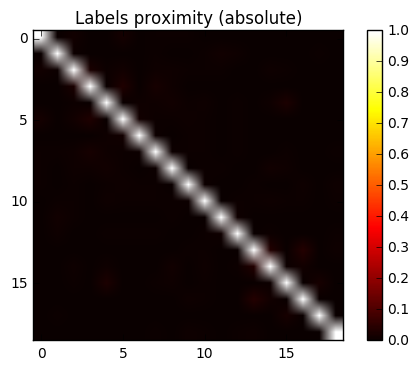

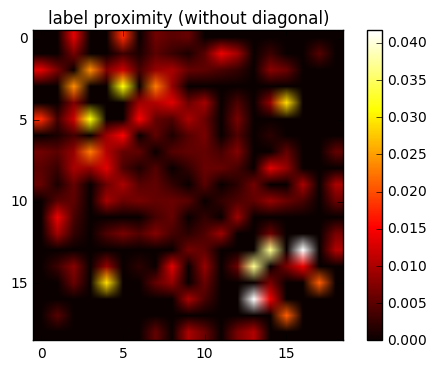

In [11]:
#We'll rather visualize an image than a 19*19 matrix.

matrix = np.zeros((y_train.shape[1],y_train.shape[1]))
edges =[]
for row in y_train :
    for i in range(len(row)):
        for j in range(len(row)):
            
            if row[i]*row[j] == 1: # both labels are activated 
                matrix[i,j] += 1
                if ([i,j] not in edges) and ([j,i] not in edges) and not i==j:
                    edges.append([i,j])

#to get frequency we'll divide by number of appearances
norm_matrix = np.copy(matrix)
for i in range(matrix.shape[0]):
    d = norm_matrix[i,i]
    norm_matrix[:,i] = norm_matrix[:,i]/d
    norm_matrix[i,:] = norm_matrix[i,:]/d
    norm_matrix[i,i] = 1

# Visualize
plt.figure()
plt.imshow(norm_matrix,cmap="hot")
plt.colorbar()
plt.title('Labels proximity (absolute)')
plt.show()

# Diagonal coefficients are not interesting, let's ditch them
norm_matrix -= np.identity(norm_matrix.shape[0])
plt.figure()
plt.imshow(norm_matrix,cmap="hot")
plt.colorbar()
plt.title('label proximity (without diagonal)')
plt.show()

### Adjacency graph

This graph is actually used in Zhang et al's method, but for us it will only be a data visualization tool.

Here's the **draw_graph** function that could be used in other projects too, for looters.

In [13]:
import networkx as nx #For those among you that use Anaconda dist, you already got this

def draw_graph(edges, weights_matrix=None, threshold=0, figsize=(8,8)):
    
    '''
    edges : liste des connected labels
    weights_matrix : labels proximity matrix
    threshold : number of occurence required to draw a connection
    figsize : size of the graph to display
    '''
    
    edges = [edge for edge in edges if weights_matrix[edge[0],edge[1]] > threshold]
    
    # additional settings (you can mess around here)
    node_size = 1600
    node_color = 'blue'
    node_alpha = 0.2
    node_text_size = 12
    edge_color = 'blue'
    edge_alpha= 0.3
    edge_tickness = 1
    edge_text_pos = 0.3
    text_font = 'sans-serif'

    plt.figure(figsize=figsize)
    # create networkx graph
    G=nx.Graph()

    # add edges
    for edge in edges:
        G.add_edge(edge[0], edge[1])

    # select shell autolocation
    graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,
                           graph_pos,
                           node_size=node_size, 
                           alpha=node_alpha,
                           node_color=node_color)
    nx.draw_networkx_edges(G, graph_pos,width=edge_tickness, alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size, font_family=text_font)
    
    # construct weights dict
    weights={}
    for i in range(len(edges)):
        weights[tuple(edges[i])] = weights_matrix.astype(int)[edges[i][0],edges[i][1]]
    
    # draw weights
    edge_labels = weights
    nx.draw_networkx_edge_labels(G, graph_pos, edge_labels=edge_labels, 
                                 label_pos=edge_text_pos)

    # show graph
    plt.title('Graphe de proximité entre les labels avec un seuil de proximité à {} occurences'.format(threshold))
    plt.show()

<div class="alert alert-warning"> Let's look at some graphs</div>

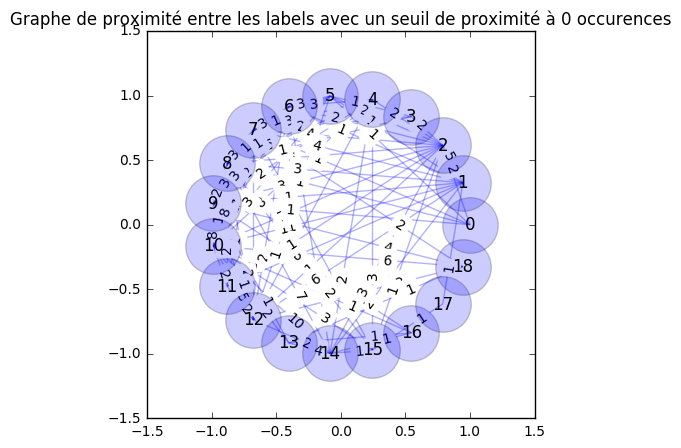

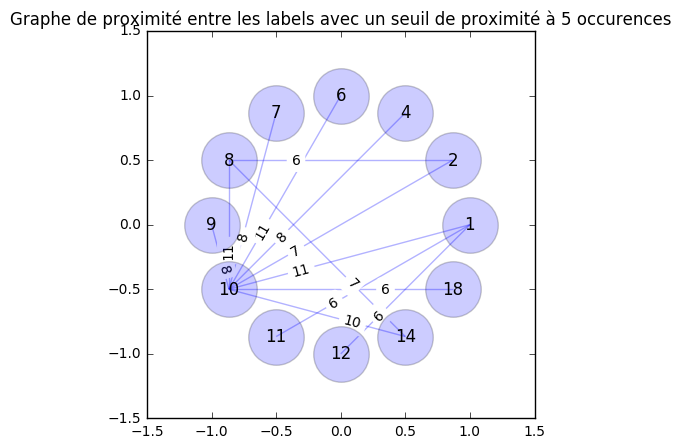

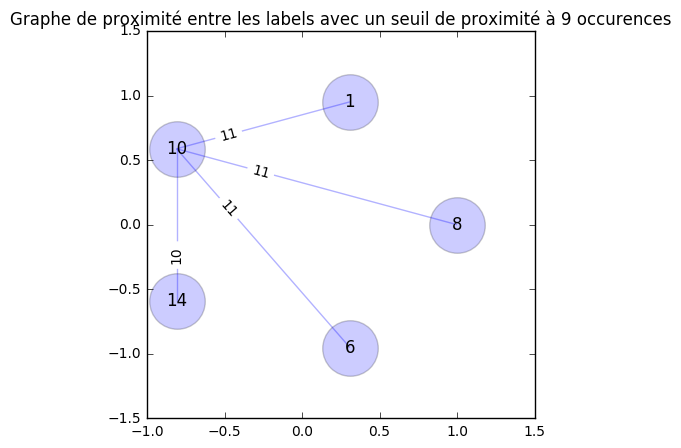

In [14]:
# CORRECTION

draw_graph(edges, matrix, figsize=(5,5), threshold=0)
draw_graph(edges, matrix, figsize=(5,5), threshold=5)
draw_graph(edges, matrix, figsize=(5,5), threshold=9)

## Design the embedding

Zhang et al use [**Deepwalk**](https://github.com/phanein/deepwalk) on the adjacency graph to build their embeding.

In our problem, multiplying the labels vectors by the normalized adjacency matrix will project our labels in a continuous space on a continuous space of 19 dimensions. Our regression will be conducted in this space.

In [15]:
def embedding_encode(y, matrix, scalor=None, return_scalor=False):
    y_conti = np.dot(y, norm_matrix)
    if scalor:
        y_conti=scalor.transform(y_conti)
    else:
        scalor = StandardScaler()
        y_conti = scalor.fit_transform(y_conti)
    
    if return_scalor:
        return y_conti, scalor
    else:
        return y_conti

y_conti_train, scalor = embedding_encode(y_train, norm_matrix, return_scalor=True)
y_conti_test = embedding_encode(y_test, norm_matrix, scalor=scalor)

The decoding part will be performed by a kNN research in the continuous space.

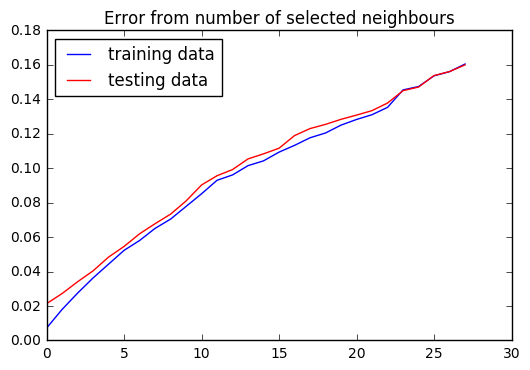

In [17]:
knn = KNeighborsClassifier()
knn.fit(y_conti_train, y_train)

def embedding_decode(y, knn, neighbors_number=2, algorithm='brute', y_train=y_train):
    indexes_of_neighbors = knn.kneighbors(y,n_neighbors=neighbors_number, return_distance=False)
    number_of_samples = indexes_of_neighbors.shape[0]
    labels = np.zeros((number_of_samples, y_train.shape[1]))
    
    for i in range(number_of_samples):
        for j in range(neighbors_number):
            labels[i, :] += y_train[indexes_of_neighbors[i,j],:]
        for j in range(labels.shape[1]):
            if labels[i,j]: labels[i,j] = 1
    
    return labels

# small optimization on neighbors_number
err_list=[]
err_list_t=[]
for n in range(2,30):
    y_train_decoded = embedding_decode(y_conti_train, knn, n )
    y_test_decoded = embedding_decode(y_conti_test, knn , n)
    error = np.sum(np.abs(y_train_decoded - y_train))
    error_t = np.sum(np.abs(y_test_decoded - y_test))
    err_list.append(error/(y_train.shape[0]*y_train.shape[1]))
    err_list_t.append(error_t/(y_test.shape[0]*y_test.shape[1]))
plt.figure()
plt.plot(err_list, label='training data')
plt.plot(err_list_t, label='testing data', color='red')
plt.legend(loc='best')
plt.title('Error from number of selected neighbours')
plt.show()

## Multidimensional Regression

We'll implement a simple model to predict coordinates in our embedded space from features, such as a random forest.

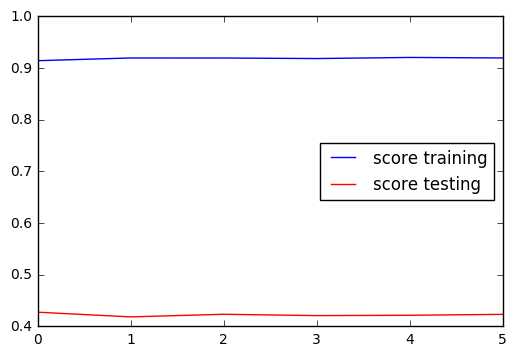

Wall time: 1min 19s


In [18]:
%%time
# mini-optimization
list_train, list_test = [],[]
for n in range(100,1101,200):
    regressor = RandomForestRegressor(n_estimators=n, n_jobs=-1)
    regressor.fit(X_train, y_conti_train)
    list_train.append(regressor.score(X_train,y_conti_train))
    list_test.append(regressor.score(X_test,y_conti_test))
plt.figure()
plt.plot(list_train, label='score training')
plt.plot(list_test, label='score testing', color='red')
plt.legend(loc='best')
plt.show()

In [19]:
# actual regression
regressor = RandomForestRegressor(n_estimators = 400, n_jobs=-1)
regressor.fit(X_train, y_conti_train)
y_conti_predict = regressor.predict(X_test)

In [21]:
# Conversion in labels
y_predict = embedding_decode(y_conti_predict, knn)

In [22]:
# Evaluate the full method precision
well_labeled = 0
for i in range(len(y_test)):
    if np.array_equal(y_test[i,:] , y_predict[i,:]):
        well_labeled +=1
print('Overall {} out of the {} testing samples were well labeled'.format(well_labeled,len(y_test)))

Overall 146 out of the 323 testing samples were well labeled


<div class="alert alert-info">Even though our embedding is dramatically simple and the precision of our regressor is more than questionable, taking the labels proximity into account took our global precision from 24 to 146 well labeled samples out of 323. That's a way to show mathemaical correctness is also a practical help!</div>

# Pour aller plus loin

Here are more XML datasets to have fun with:
    - http://mulan.sourceforge.net/datasets-mlc.html 
    - http://manikvarma.org/downloads/XC/XMLRepository.html

You can try on these to build the adjacency graph and use [**Deepwalk**](https://github.com/phanein/deepwalk) on it !